<a href="https://colab.research.google.com/github/aleaguilar0094-ops/Computer-vision/blob/main/MobileNet_without_modifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data preprocessing


In [ ]:
from google.colab import drive #It get access to a folder where the data is
drive.mount('/content/drive')
from pathlib import Path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data preprocessing

Libraries are indicated

In [ ]:
import hashlib
from PIL import Image
import glob
from itertools import chain

In [ ]:
#Libraries are imported

import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
from PIL import Image
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, random_split, DataLoader

##Paths and images are transformed, partitioned, and loaded into DataLoaders for the model.

##It is indicated how the datasets will be transformed

In [ ]:
'''
It transfors the images according to model requirements
*Resizes the shortest size of the image to 256 pixels, maintaning the aspect ratio.
*Uses bilinear interpolation
*Takes the center 224x224 region of the resized image
*Converts the image to a PyTorch tensor
*Normalize the image
'''
transform = transforms.Compose([
    transforms.Resize(256),  #By default the interpolation is bilinear
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

##2 datasets are indicated

The datasets are obtained from a folder in the PC

In [ ]:
wheat = r"C:/Users/TuUsuario/Proyects/Datasets/Wheat Augmented Dataset"
#coffee = r"C:/Users/TuUsuario/Proyects/Datasets/Coffee Dataset"
full_dataset = datasets.ImageFolder(root=wheat, transform=transform)
num_classes = 5 #The number of classes of the model is specified
#full_dataset = datasets.ImageFolder(root= coffee, transform=transform)
#num_classes = 3 #The number of classes of the model is specified
class_names = full_dataset.classes
print(class_names)

The datasets are obtained from Google Drive

In [ ]:
full_dataset = datasets.ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Wheat Augmented Dataset', transform=transform)
num_classes = 5 #The number of classes of the model is specified
#full_dataset = datasets.ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Coffee Dataset', transform=transform)
#num_classes = 3 #The number of classes of the model is specified

In [ ]:
#The dataset is split. 80% of the data will be for training, 10% for validation and 10% for testing
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size- val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

#Hyperparameters and functions for training the model

###Libraries are indicated

In [ ]:
import numpy as np

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

It is confirmed wich device is being used

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


###Hyperparameters and functions

Hyperparametres are indicated

In [ ]:
batch_size = 32 #The number of batches is specified
num_epochs = 5 #The number of epochs is specified
learning_rate = 0.005 #The learning rate is specified

A function to upload the data to the models

In [ ]:
def get_data():
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False) #It divides the data into batches and shuffles it
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)   #It divides the data into batches and shuffles it
  return train_loader, valid_loader

A function to train a batch

In [ ]:
def train_batch(x, y, model, optimizer, loss_function): #It needs an input, an output, optimizer and loss function
  model.train() #It sets the model in training mode
  prediction = model(x) #It classifies an image
  batch_loss = loss_function(prediction, y) #Calculates the loss between the model's predicitions and the true labels.
  batch_loss.backward() #Computes the gradients of the loss with respect to the model's parameters
  optimizer.step() #Updates the model's parameters using the computed gradients.
  optimizer.zero_grad() #Clears the gradients stored in the model's parameters
  return batch_loss.item() #Returns the scalar value of the loss for a batch


The model is defined

In [ ]:
weights =  models.MobileNet_V3_Small_Weights.DEFAULT #It sets the weights of a prtrained model
model = models.mobilenet_v3_small(weights=weights).to(device) #The model is indicated

A function to obtain tha validation loss of each batch

In [ ]:
def val_batch(x, y, model, optimizer, loss_function): #This function calculate the loss using the validation data.
  model.eval() #Sets the model to evaluation mode.
  with torch.no_grad(): #The gradients are not computed during validation.
    prediction = model(x) #It classifies an image.
    batch_loss = loss_function(prediction, y) #Calculates the loss between the model's predicitions and the true labels.
  return batch_loss.item() #Returns the scalar value of the loss for a batch.

A function to obtain model's accuracy

In [ ]:
def predict(x, model):
  model.eval() #Sets he model to evaluation mode
  with torch.no_grad(): #The gradients are not computed during validation.
    prediction = model(x) #It classifies an image.
    _, predicted = torch.max(prediction, 1) #It gets the label with the highest obtained probability
  return predicted #It returns the label

A function where the hyperparameters and the model are joined

In [ ]:
#The model is indicated. In this case the transfer learning model.
def get_model(model):
  #The layers of model are freeze. Weights are no updated anymore to reduce errors,
  #so a stochastic gradient descent is not required.
  for param in model.parameters():
      param.requires_grad = False
  #It sets the seed of the random number generator to a fixed value.
  #This helps that the weights of the last layer, which is trained, remain the same in multiple itiretations, so the results will be reproducible.
  torch.manual_seed(0)
  #The classifier is rebuild.
  model.classifier = nn.Sequential(
   nn.Linear(in_features=576, out_features=1024, bias=True),
   nn.Hardswish(inplace=True),
   nn.Dropout(p=0.5, inplace=False),
   nn.Linear(in_features=1024, out_features=num_classes, bias=True))
  loss_function = nn.CrossEntropyLoss() #The loss function is CrossEntropy because ia a multiclass classification problem.
  optimizer = optim.SGD(model.parameters(), lr=learning_rate) #It sets the optimizer.
  return model.to(device), loss_function, optimizer

The function to train the model

In [ ]:
# Start a timer to monitor the time of trainning
from timeit import default_timer as timer

def training_model(model, weights):
  start_time = timer()

  training_data, validation_data = get_data() #It gets the preprepared and shuffled data.
  model, loss_fn, optimizer = get_model(model) #From the function get model(), it obtains th model, loss_fn and optimizer

  train_losses, train_accuracies = [], [] #It creates an array to save train losses and accuracies.
  val_losses, val_accuracies = [], [] #It creates an array to save validation losses and accuracies.

  print(type(model).__name__)

  for epoch in range(num_epochs): #It iterates through the number of epochs
      print(f" epoch {epoch + 1}/{num_epochs}") #Print the number of epoch

      train_epoch_losses = [] #An array is created to save the train epoch losses
      val_epoch_losses = [] #An array is created to save the validation epoch losses
      train_correct = 0 #The number of right predicitions in the training mode is set to 0
      train_total = 0 #The total number of predicition in the training mode is set to 0
      val_correct = 0 #The number of right predicitions in the validation mode is set to 0
      val_total = 0 #The total number of predicition in the validation mode is set to 0

      for ix, batch in enumerate(training_data): #It iterates through the batches of training data
          x, y = batch #From the batch it gets an intput and output
          # Convert labels to LongTensor before moving to device
          y = y.long()
          x, y = x.to(device), y.to(device) #The variables are sent to the device
          batch_loss = train_batch(x, y, model, optimizer, loss_fn) #A scalar number is get after the model was trained and the loss obtained
          train_epoch_losses.append(batch_loss) #The train batch loss is added to a list

          predicted = predict(x,model) #A classifcation for the model is obtained
          train_correct += (predicted == y).sum().item() #The classification and the real label are compared. If they are equal, a point is sumed up to the number of right predicitions.
          train_total += y.size(0) #It gets the number of total predicitons

      train_epoch_loss = np.array(train_epoch_losses).mean() #It obtains the average of train losses
      train_epoch_accuracy = train_correct / train_total #It obtains the train accuracy of each epoch

      for ix, batch in enumerate(iter(validation_data)): #It iterates through the batches of validation data
          x, y = batch #From the batch it gets an intput and output
          # Convert labels to LongTensor before moving to device
          y = y.long()
          x, y = x.to(device), y.to(device) #The variables are sent to the device

          val_batch_loss = val_batch(x, y, model, optimizer, loss_fn) #A scalar number is get after the loss is obtained with the validation data
          val_epoch_losses.append(val_batch_loss)  #The validation batch loss is added to a list

          validation = predict(x,model) #A classifcation for the model is obtained
          val_correct += (validation == y).sum().item() #The validation and the real label are compared. If they are equal, a point is sumed up to the number of right predicitions.
          val_total += y.size(0) #It gets the number of total predicitons

      validations_epoch_loss = np.array(val_epoch_losses).mean() #It obtains the average of validation losses
      val_epoch_accuracy = val_correct / val_total #It obtains the validation accuracy of each epoch

      train_losses.append(train_epoch_loss) #It adds the loss of the epoch to the array of train losses
      train_accuracies.append(train_epoch_accuracy) #It adds the accuracy of the epoch to the array of train accuracies
      val_losses.append(validations_epoch_loss) #It adds the loss of the epoch to the array of validation losses
      val_accuracies.append(val_epoch_accuracy) #It adds the accuracy of the epoch to the array of validation accuracies

      print(f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_accuracy:.4f} |Val Loss: {validations_epoch_loss:.4f} | Val Acc: {val_epoch_accuracy:.4f}")
    #It prints all the measures

  end_time = timer()
  return end_time-start_time, train_losses, train_accuracies, val_losses, val_accuracies

#Model training

In [ ]:
training_time, train_losses, train_accuracies, val_losses, val_accuracies = training_model(model, weights)

MobileNetV3
 epoch 1/5
Train Loss: 1.4297 | Train Acc: 0.6412 |Val Loss: 1.2502 | Val Acc: 0.8000
 epoch 2/5
Train Loss: 1.1293 | Train Acc: 0.8478 |Val Loss: 0.9543 | Val Acc: 0.8700
 epoch 3/5
Train Loss: 0.8936 | Train Acc: 0.8915 |Val Loss: 0.7459 | Val Acc: 0.8840
 epoch 4/5
Train Loss: 0.7104 | Train Acc: 0.9100 |Val Loss: 0.5903 | Val Acc: 0.9000
 epoch 5/5
Train Loss: 0.5817 | Train Acc: 0.9233 |Val Loss: 0.4824 | Val Acc: 0.9180


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False)
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for ix, batch in enumerate(iter(test_loader)):
      x, y = batch
      x = x.to(device) # Move input tensor to the device
      outputs = model(x)
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(y.cpu().numpy())

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Precision and recall (for multi-class classification)
precision = precision_score(all_labels, all_preds, average='macro')  # or 'micro', 'weighted'
recall = recall_score(all_labels, all_preds, average='macro')


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Confusion Matrix:
 [[88  0  0  1  0]
 [ 0 98  2  1  0]
 [15 10 85  1  0]
 [ 1  2  1 94  0]
 [ 0  0  0  3 98]]
Precision: 0.9286
Recall: 0.9309


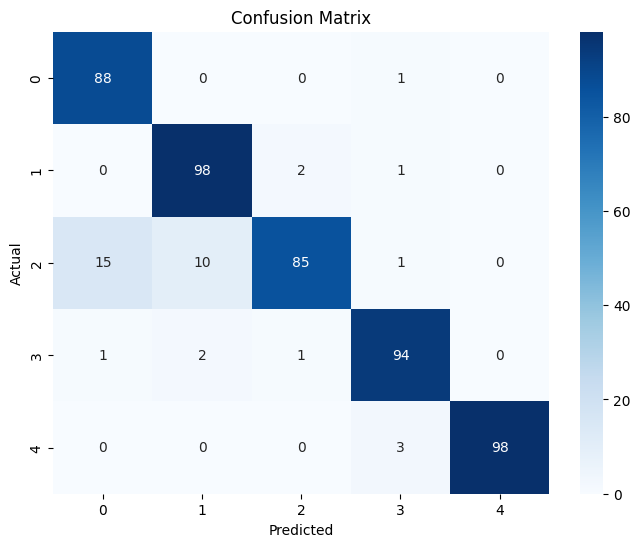

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Results and graphs

Libraries are imported

In [ ]:
import pandas as pd
from datetime import datetime
import io
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from google.colab import files

A function to print the results in a csv file is defined

In [ ]:
def print_results():
  #It creates an array with the columns Train loses, train accuracies, val losses and val accuracies, and the list of values are set.
  results={"Train losses":train_losses,
                "Train accuracies": train_accuracies,
                "Val losses": val_losses,
                "Val accuracies": val_accuracies}

  # Create an in-memory bytes buffer using io.BytesIO to temporarily hold the model's state_dict.
  buffer = io.BytesIO()
  # Save the model's parameters (state_dict) into the buffer instead of a file on disk.
  torch.save(model.state_dict(), buffer)
  # Calculate the size of the saved model in megabytes (MB).
  size_mb = buffer.getbuffer().nbytes / (1024 ** 2)

  # Calculate the total number of parameters in the model.
  # p.numel() returns the number of elements in each parameter tensor.
  total_params = sum(p.numel() for p in model.parameters())


  #It converts the array to a dataframe
  results = pd.DataFrame(results)
  #It creates an extra row where the values of train losses, train accuracies, val losses, val accuracies will be empty.
  #However, it will create a new column where the model of size, total number of parameters and training time will be printed
  extra_row = pd.DataFrame({
      "Train losses": [""],
      "Train accuracies": [""],
      "Val losses": [""],
      "Val accuracies": [""],
      "Model size": [size_mb],
      "Total number of parameters": [total_params],
      "Training time": [training_time]
  })

  now = datetime.now() #It gets the current date and time
  results = pd.concat([results, extra_row], ignore_index=True) #The data frame and the extra row are joined

  filename = f"{type(model).__name__}_{now.strftime('%Y-%m-%d_%H-%M-%S')}.csv" #The file name is set.The file name is the number of the model and the date and time. This is for deferentiate different files and know the order, which were created

  results.to_csv(filename, index=False)#The file is created

  files.download(filename) #The file is downloaded to the device

A function to depict train loses, train accuracies, val losses and val accuracies is created

In [ ]:
from google.colab import files
def print_graphs():
  now = datetime.now() #It gets the current date and time
  epochs = np.arange(num_epochs)+1 #This number is created just for creating the graphs
  fig, axs = plt.subplots(1, 2, figsize=(10, 4)) #A frame of graphs is created

  #The first graph is defined
  axs[0].plot(epochs, train_accuracies, 'bo',
          label='Training accuracy') #The line for plotting train accuracies is defined whith blue markers
  axs[0].plot(epochs, val_accuracies, 'r',
          label='Validation accuracy') #The line for plotting validations accuracies is defined with red markers
  axs[0].set_title('Training and validation accuracies')# The title of the graph is defined
  axs[0].set_xlabel('Epochs') #The title of the x label is defined
  axs[0].set_ylabel('Accuracy') #The title of the y label is defined
  axs[0].legend() #It is indicated that a legend is needed
  axs[0].grid() #There is a for the graph

#The second graph is defined
  axs[1].plot(epochs, train_losses, 'bo',
          label='Train loss') #The line for plotting train loss is defined whith blue markers
  axs[1].plot(epochs, val_losses, 'r',
          label='Validation loss') #The line for plotting validations accuracies is defined with red markers
  axs[1].set_title('Training and validation Losses') # The title of the graph is defined
  axs[1].set_xlabel('Epochs')#The title of the x label is defined
  axs[1].set_ylabel('Loss') #The title of the y label is defined
  axs[1].legend() #It is indicated that a legend is needed
  axs[1].grid()  #There is a for the graph

  plt.tight_layout() #It automatically adjusts the spacing between subplots and plot elements in a figure
  plots_name = f"{type(model).__name__}_{now.strftime('%Y-%m-%d_%H-%M-%S')}.png" #The file name is set.The file name is the number of the model and the date and time. This is for deferentiate different files and know the order, which were created
  plt.savefig(plots_name) #The graph files are saved
  files.download(plots_name) #The graph files are saved

In [ ]:
print_results()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

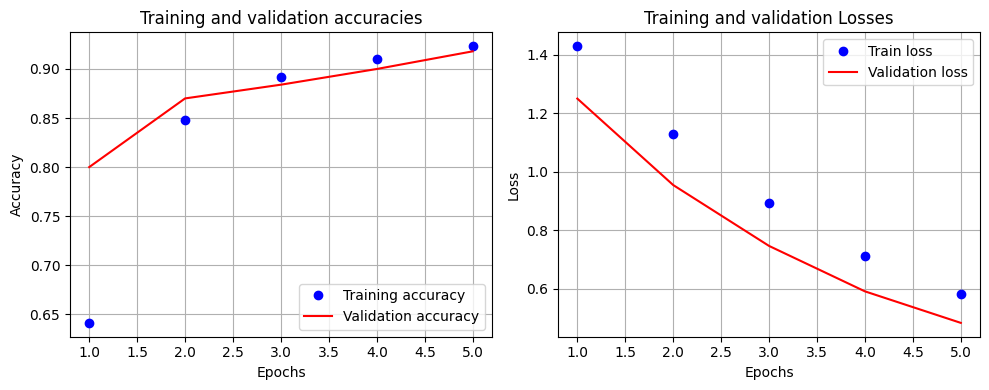

In [ ]:
print_graphs()